<a href="https://colab.research.google.com/github/rushin682/spatial-segmentation-course/blob/main/segmentation_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Need Install Package paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.makedirs('/content/drive/MyDrive/SpatialCellSeg/', exist_ok=True)
os.makedirs('/content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io', exist_ok=True)

# save colab here
os.chdir('/content/drive/MyDrive/SpatialCellSeg/')

In [ ]:
!pip install sopa[cellpose,wsi]

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of distributed to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.8 MB/s

In [ ]:
!pip install spatialdata-plot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install jedi>=0.16

In [ ]:
!pip install comseg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.0/707.0 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Successfully uninstalled traitlets-5.7.1


## Begin Tutorial

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from pathlib import Path

import spatialdata as sd
import spatialdata_plot

import sopa

# optional: set the parallelization backend to use dask
sopa.settings.parallelization_backend = "dask"

## Download xenium file

In [ ]:
import os
from pathlib import Path
import subprocess

urls = [
    "https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_human_Pancreas_FFPE/Xenium_V1_human_Pancreas_FFPE_he_image.ome.tif",
    "https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_human_Pancreas_FFPE/Xenium_V1_human_Pancreas_FFPE_he_imagealignment.csv",
    "https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_human_Pancreas_FFPE/Xenium_V1_human_Pancreas_FFPE_outs.zip",
]


path = Path("/content/drive/MyDrive/SpatialCellSeg/").resolve()
# luca's workaround for pycharm
if not str(path).endswith("xenium_2.0.0_pancreas_io"):
    path /= "xenium_2.0.0_pancreas_io"
    assert path.exists()

path = path / "data"

##
# download the data
for url in urls:
    filename = Path(url).name
    os.makedirs(path, exist_ok=True)
    command = f"curl -o {path/filename} {url}"
    subprocess.run(command, shell=True, check=True)

# ##
# unzip the data
subprocess.run(
    f"unzip -o {path}/Xenium_V1_human_Pancreas_FFPE_outs.zip -d {path}/",
    shell=True,
    check=True,
)

CompletedProcess(args='unzip -o /content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data/Xenium_V1_human_Pancreas_FFPE_outs.zip -d /content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data/', returncode=0)

In [ ]:
from spatialdata_io import xenium
import spatialdata as sd

##
from pathlib import Path
import shutil

##
path = Path('/content/drive/MyDrive/SpatialCellSeg/').resolve()
# luca's workaround for pycharm
if not str(path).endswith("xenium_2.0.0_pancreas_io"):
    path /= "xenium_2.0.0_pancreas_io"
    assert path.exists()

path_read = path / "data"
path_write = path / "data.zarr"

##
print("parsing the data... ", end="")
sdata = xenium(
    path=str(path_read),
    n_jobs=8,
    cell_boundaries=True,
    nucleus_boundaries=True,
    morphology_focus=True,
)
print("done")

##
print("writing the data... ", end="")
if path_write.exists():
    shutil.rmtree(path_write)
sdata.write(path_write)
print("done")

##
sdata = sd.SpatialData.read("/content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data.zarr/")
print(sdata)
##

/usr/local/lib/python3.11/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


parsing the data... INFO     reading /content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data/cell_feature_matrix.h5        


<ipython-input-7-5fbc7e2302ab>:20: DeprecationWarning: `cell_boundaries` is being deprecated as an argument to `xenium.xenium` in SpatialData version 0.1, switch to `cells_boundaries` instead.
  sdata = xenium(
<ipython-input-7-5fbc7e2302ab>:20: DeprecationWarning: The default value of `cells_as_circles` will change to `False` in the next release. Please pass `True` explicitly to maintain the current behavior.
  sdata = xenium(


INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
done
writing the data... 

/usr/local/lib/python3.11/dist-packages/tifffile/tifffile.py:8860: UserWarning: <tifffile.TiffPage 0 @16> reading array from closed file
  warnings.warn(


INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data.zarr). Please see   
         the documentation of `is_self_contained()` to understand the implications of working with SpatialData     
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data.zarr                                  
done


/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: Use

SpatialData object, with associated Zarr store: /content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 27502, 14896), (3, 13751, 7448), (3, 6875, 3724), (3, 3437, 1862), (3, 1718, 931)
│     └── 'morphology_focus': DataTree[cyx] (5, 13770, 34155), (5, 6885, 17077), (5, 3442, 8538), (5, 1721, 4269), (5, 860, 2134)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (13770, 34155), (6885, 17077), (3442, 8538), (1721, 4269), (860, 2134)
│     └── 'nucleus_labels': DataTree[yx] (13770, 34155), (6885, 17077), (3442, 8538), (1721, 4269), (860, 2134)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (140702, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (140702, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (136531, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (140702, 377)
with coordinate 

## SpatialData (a tool to align and store spatial samples)

In [ ]:
zarr_path = Path("/content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data.zarr")

In [ ]:
sdata = sd.read_zarr(zarr_path)

/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/usr/local/lib/python3.11/dist-packages/zarr/creation.py:614: Use

In [ ]:
sdata

SpatialData object, with associated Zarr store: /content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 27502, 14896), (3, 13751, 7448), (3, 6875, 3724), (3, 3437, 1862), (3, 1718, 931)
│     └── 'morphology_focus': DataTree[cyx] (5, 13770, 34155), (5, 6885, 17077), (5, 3442, 8538), (5, 1721, 4269), (5, 860, 2134)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (13770, 34155), (6885, 17077), (3442, 8538), (1721, 4269), (860, 2134)
│     └── 'nucleus_labels': DataTree[yx] (13770, 34155), (6885, 17077), (3442, 8538), (1721, 4269), (860, 2134)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (140702, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (140702, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (136531, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (140702, 377)
with coordinate 

## Pancreas Xenium sample

### Different components:
A SpatialData object is designed to store and manage spatial biological data. It is composed of several key components that allow for comprehensive analysis and visualization of spatial datasets. Below are the main components of a SpatialData object:

- **Images (DataArrays)**
  - **Description:** The Images component stores the visual data, such as microscopy images or other spatially resolved imaging data.
  - **Purpose:** Provides the primary visual data that forms the basis of spatial analysis.
  - **Example:** High-resolution microscopy images of tissue sections.

- **Labels (DataArrays)**
  - **Description:** The Labels component contains categorical or numerical annotations assigned to specific regions or points within the images.
  - **Purpose:** Allows for the classification or categorization of spatial features.
  - **Example:** Cell type labels assigned to specific regions in an image.

- **Points (GeoDataFrame)**
  - **Description:** The Points component stores the coordinates of specific points of interest within the spatial data.
  - **Purpose:** Identifies precise locations within the images that are relevant for analysis.
  - **Example:** Coordinates of cell centroids or specific landmarks.

- **Shapes (GeoDataFrame)**
  - **Description:** The Shapes component stores geometric shapes that define regions of interest within the spatial data.
  - **Purpose:** Allows for the definition of complex regions or boundaries within the images.
  - **Example:** Polygon shapes outlining specific tissue regions.

- **Tables (AnnData)**
  - **Description:** The Tables component contains tabular data associated with the spatial data, such as metadata or feature measurements.
  - **Purpose:** Provides additional information or measurements linked to the spatial data.
  - **Example:** Gene expression data corresponding to specific cells or regions.

### Basic plotting

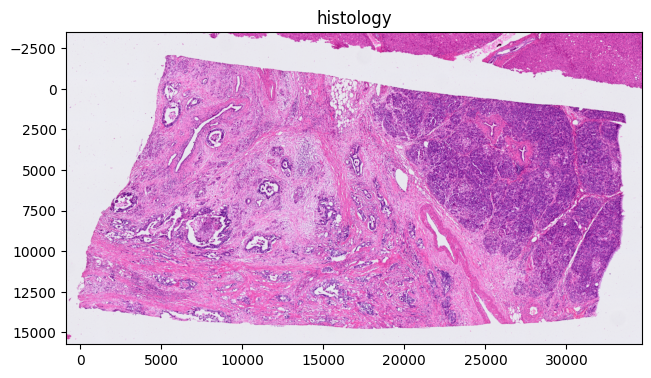

In [ ]:
sdata.pl.render_images("he_image").pl.show(coordinate_systems='global', title="histology")

In [ ]:
sdata.pl.render_images("morphology_focus").pl.show(coordinate_systems='global', title="morphology")

INFO     Rasterizing image for faster rendering.                                                                   


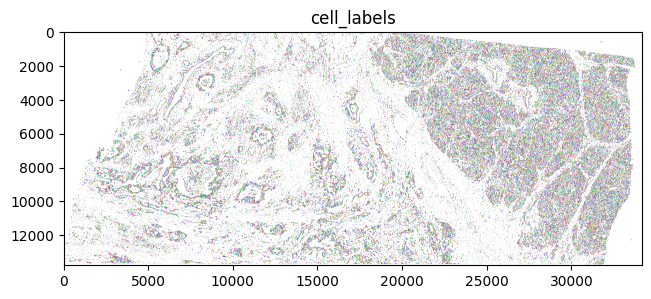

In [ ]:
sdata.pl.render_labels('cell_labels').pl.show(coordinate_systems='global', title="cell_labels")

In [ ]:
sdata.pl.render_shapes('cell_circles').pl.show(coordinate_systems='global', title="cell_circles")

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


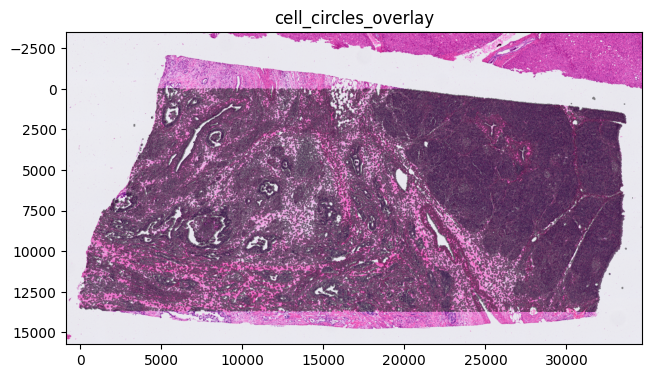

In [ ]:
sdata.pl.render_images('he_image')\
    .pl.render_shapes('cell_circles', outline_alpha=0.5, fill_alpha=0.5)\
        .pl.show(coordinate_systems='global', title="cell_circles_overlay")

In [ ]:
sdata.pl.render_images('morphology_focus')\
    .pl.render_shapes('cell_circles', outline_alpha=0.5, fill_alpha=0, outline_color='white')\
        .pl.show(coordinate_systems='global', title="cell_circles_dapi_overlay")

## Tissue Segmentation

In [ ]:
sopa.segmentation.tissue(sdata, image_key='he_image')

In [ ]:
sdata

SpatialData object, with associated Zarr store: /content/drive/MyDrive/SpatialCellSeg/xenium_2.0.0_pancreas_io/data.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 27502, 14896), (3, 13751, 7448), (3, 6875, 3724), (3, 3437, 1862), (3, 1718, 931)
│     └── 'morphology_focus': DataTree[cyx] (5, 13770, 34155), (5, 6885, 17077), (5, 3442, 8538), (5, 1721, 4269), (5, 860, 2134)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (13770, 34155), (6885, 17077), (3442, 8538), (1721, 4269), (860, 2134)
│     └── 'nucleus_labels': DataTree[yx] (13770, 34155), (6885, 17077), (3442, 8538), (1721, 4269), (860, 2134)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (140702, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (140702, 2) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (136531, 1) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (2, 1) (2D shape

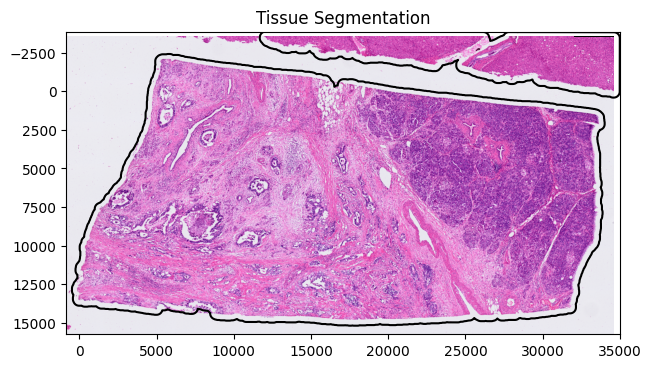

In [ ]:
sdata.pl.render_images('he_image')\
    .pl.render_shapes('region_of_interest', outline_alpha=1.0, fill_alpha=0, outline_color='black')\
        .pl.show(coordinate_systems='global', title="Tissue Segmentation")

## Annotating with Napari

In [ ]:
from napari_spatialdata import Interactive

interactive = Interactive(sdata)
interactive.run()

In [ ]:
sdata

In [ ]:
sdata.pl.render_images('he_image')\
    .pl.render_shapes('annotations', outline_alpha=1.0, fill_alpha=0, outline_color='black')\
        .pl.show(coordinate_systems='global', title="Basic Annotation")

## ROI Crop (Optional)

In [ ]:
'''
annotations = sdata.shapes["annotations"]
# annotations

# Step 1: Extract the polygon from the geodataframe
polygon = annotations.geometry.iloc[0]

# Step 2: Get the bounds of the polygon
min_x, min_y, max_x, max_y = polygon.bounds

# Step 3: Print the coordinates
print(f"Minimum X: {min_x}, Maximum X: {max_x}")
print(f"Minimum Y: {min_y}, Maximum Y: {max_y}")
'''
min_x = 6500
min_y = 7500
max_x = 9500
max_y = 10500

In [ ]:
sdata_cropped = sdata.query.bounding_box(
    min_coordinate=[min_x, min_y], max_coordinate=[max_x, max_y], axes=("x", "y"), target_coordinate_system='global'
)

sdata_cropped

/usr/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 2332, 2332), (3, 1166, 1166), (3, 583, 583), (3, 291, 291), (3, 146, 146)
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 3000), (5, 1500, 1500), (5, 750, 750), (5, 375, 375), (5, 188, 188)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (188, 188)
│     └── 'nucleus_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (188, 188)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (3502, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (3491, 2) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (3413, 1) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (1, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3491, 377)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), morp

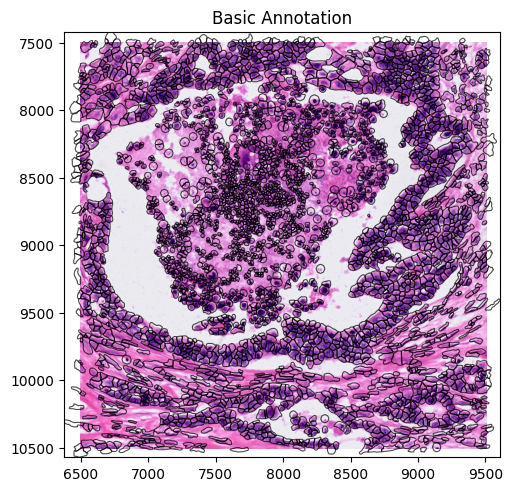

In [ ]:
sdata_cropped.pl.render_images('he_image', alpha=1.0)\
    .pl.render_shapes('cell_boundaries', outline_alpha=0.7, fill_alpha=0, outline_color='black', outline_width=0.8)\
        .pl.show(coordinate_systems='global', title="Basic Annotation")

In [ ]:
sdata_cropped.tables["table"]

AnnData object with n_obs × n_vars = 3491 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## CellPose Segmentation

In [ ]:
sopa.make_image_patches(sdata_cropped, patch_width=500, patch_overlap=0, image_key='morphology_focus')
sdata_cropped

[INFO] (sopa.patches._patches) 36 patches were added to sdata['image_patches']


SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 2332, 2332), (3, 1166, 1166), (3, 583, 583), (3, 291, 291), (3, 146, 146)
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 3000), (5, 1500, 1500), (5, 750, 750), (5, 375, 375), (5, 188, 188)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (188, 188)
│     └── 'nucleus_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (188, 188)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (3502, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (3491, 2) (2D shapes)
│     ├── 'image_patches': GeoDataFrame shape: (36, 3) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (3413, 1) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (1, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3491, 377)
with coordinate syst

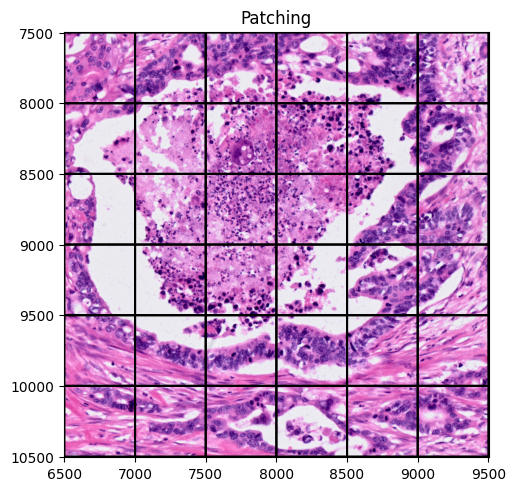

In [ ]:
sdata_cropped.pl.render_images('he_image')\
    .pl.render_shapes('image_patches', outline_alpha=1.0, fill_alpha=0, outline_color='black')\
        .pl.show(coordinate_systems='global', title="Patching")

In [ ]:
sopa.utils.get_channel_names(sdata_cropped, image_key='morphology_focus')

array(['DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'AlphaSMA/Vimentin',
       'dummy'], dtype='<U22')

In [ ]:
cellpose_model_kwargs = {'gpu': True}
sopa.segmentation.cellpose(sdata_cropped, image_key='morphology_focus', channels=["DAPI"], diameter=30, flow_threshold=2, cellprob_threshold=-6, min_area=400, cellpose_model_kwargs=cellpose_model_kwargs)

[INFO] (sopa._settings) Using dask backend
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36971'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33243'
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52310
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52298
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52316


[                                        ] | 0% Completed | 18.1s

INFO:distributed.core:Starting established connection to tcp://127.0.0.1:44528


[                                        ] | 0% Completed | 18.6s

INFO:distributed.core:Starting established connection to tcp://127.0.0.1:44542


INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:52316; closing.
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:36971'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:33243'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:44542; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:52298; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:44528; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:52310; closing.
[INFO] (sopa.segmentation._stainings) Found 3743 total cells
Resolving conflicts: 100%|██████████| 368/368 [00:00<00:00, 12754.02it/s]
[INFO] (sopa.segmentation._stainings) Added 3743 cell boundaries in sdata['cellpose_boundaries']


In [ ]:
sdata_cropped
# Add a comment for "tab completions"
# Does this work?


SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 2332, 2332), (3, 1166, 1166), (3, 583, 583), (3, 291, 291), (3, 146, 146)
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 3000), (5, 1500, 1500), (5, 750, 750), (5, 375, 375), (5, 188, 188)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (188, 188)
│     └── 'nucleus_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (188, 188)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (3502, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (3491, 2) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (3743, 1) (2D shapes)
│     ├── 'image_patches': GeoDataFrame shape: (36, 3) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (3413, 1) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (1, 1) (2D sha

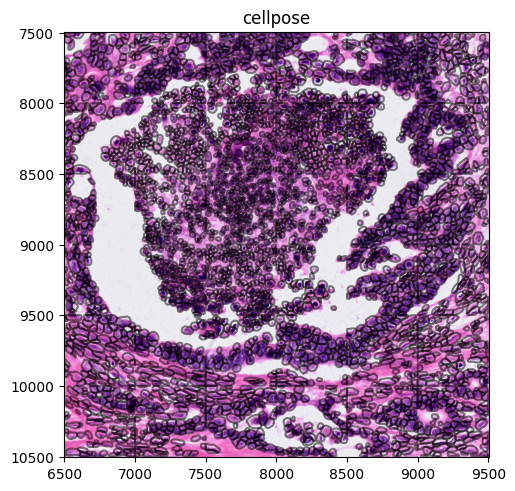

In [ ]:
sdata_cropped.pl.render_images('he_image').pl.render_shapes('cellpose_boundaries', fill_alpha=0.0, outline_alpha=0.5, outline_color='black').pl.show(title='cellpose')

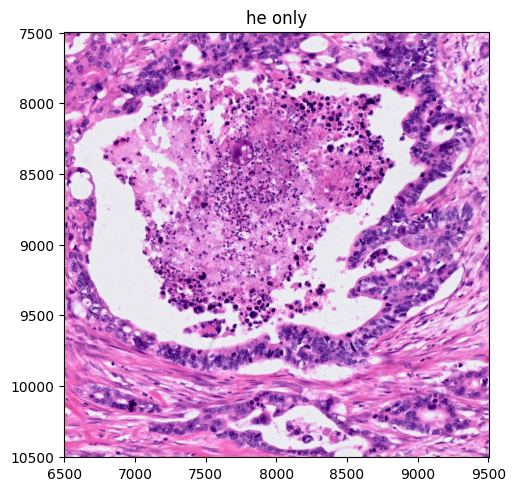

In [ ]:
sdata_cropped.pl.render_images('he_image').pl.show(title='he only')

## Baysor Segmentation (Optional)

## ComSeg Segmentation (Optional)

In [ ]:
sdata_cropped.tables['table']

AnnData object with n_obs × n_vars = 3491 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [ ]:
sopa.make_transcript_patches(
    sdata_cropped,
    patch_width=400,
    patch_overlap=0,
    prior_shapes_key="cellpose_boundaries",
    write_cells_centroids=True,
)

[########################################] | 100% Completed | 1.84 s


[INFO] (sopa.patches._transcripts) 4 patche(s) were added to sdata['transcripts_patches']


In [ ]:
sdata_cropped

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 2332, 2332), (3, 1166, 1166), (3, 583, 583), (3, 291, 291), (3, 146, 146)
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 3000), (5, 1500, 1500), (5, 750, 750), (5, 375, 375), (5, 188, 188)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (188, 188)
│     └── 'nucleus_labels': DataTree[yx] (3000, 3000), (1500, 1500), (750, 750), (375, 375), (188, 188)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 12) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (3502, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (3491, 2) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (3743, 1) (2D shapes)
│     ├── 'image_patches': GeoDataFrame shape: (36, 3) (2D shapes)
│     ├── 'nucleus_boundaries': GeoDataFrame shape: (3413, 1) (2D shapes)
│     ├── 'region_of_interest': GeoDataFrame shape: (1, 1) (2D sha

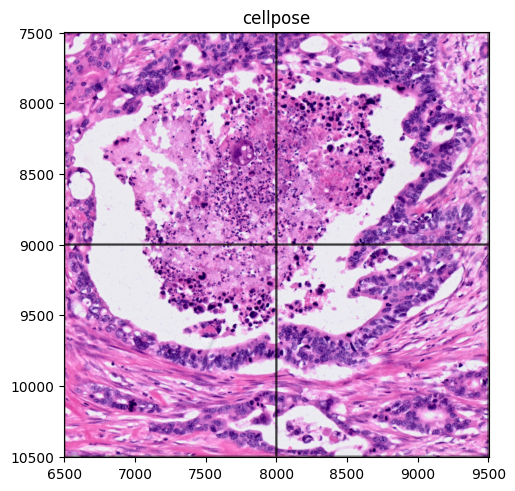

In [ ]:
sdata_cropped.pl.render_images('he_image').pl.render_shapes('transcripts_patches', fill_alpha=0.0, outline_alpha=0.5, outline_color='black').pl.show(title='cellpose')

In [ ]:
sdata_cropped.tables["table"]

In [ ]:
config = {'dict_scale': {'x': 1, 'y': 1, 'z': 1}, 'mean_cell_diameter': 15, 'max_cell_radius': 15, 'k_nearest_neighbors': 5, 'norm_vector': False, 'alpha': 0.5, 'allow_disconnected_polygon': True, 'min_rna_per_cell': 10, 'gene_column': 'feature_name'}

In [ ]:
sopa.segmentation.comseg(sdata_cropped, config=config)

[INFO] (sopa._settings) Using dask backend
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37985'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41841'
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:43030
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:43038
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:43044


INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:43044; closing.
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:37985'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:41841'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:43038; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:43030; closing.
INFO:distributed.nanny:Worker process 11326 was killed by signal 9
INFO:distributed.nanny:Worker process 11323 was killed by signal 9
Reading transcript-segmentation outputs: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
Resolving conflicts: 0it [00:00, ?it/s]
[INFO] (sopa.segmentation._transcripts) Added sdata.tables['table'], and 3032 cell boundaries to sdata['comseg_boundaries']


In [ ]:
sdata_cropped

In [ ]:
sdata_cropped.pl.render_images('he_image').pl.render_shapes('comseg_boundaries', fill_alpha=0.0, outline_alpha=0.5, outline_color='black').pl.show(title='comseg')

In [ ]:
sdata_cropped.pl.render_images('he_image').pl.render_shapes('cellpose_boundaries', fill_alpha=0.0, outline_alpha=0.5, outline_color='black').pl.show(title='cellpose')

## Aggregating Transcripts to Cells

In [ ]:
sopa.aggregate(sdata_cropped, aggregate_genes=True, aggregate_channels=True, image_key='morphology_focus', shapes_key="cellpose_boundaries", gene_column="feature_name", min_transcripts=10, key_added='cellpose_table')

In [ ]:
sopa.aggregate(sdata_cropped, aggregate_genes=True, aggregate_channels=True, image_key='morphology_focus', shapes_key="comseg_boundaries", gene_column="feature_name", min_transcripts=10, key_added='comseg_table')

In [ ]:
sdata_cropped.tables["cellpose_table"]

In [ ]:
sdata_cropped.tables["comseg_table"]

## Annotating Cells with Tangram (Optional)

In [ ]:
import anndata

adata_reference = anndata.read_h5ad("adata_reference.h5ad")

sopa.utils.tangram_annotate(sdata_cropped, adata_reference, "cell_type")

### Staining-based

- For now, our fluorescence-based annotation is very simple. We provide a dictionary where a channel is associated with a population. Then, each cell is associated with the cell type whose corresponding channel is the brightest (according to a certain Z-score).

## Visualize with Xenium Explorer

In [ ]:
sdata_cropped

In [ ]:
del sdata_cropped.tables["table"]

In [ ]:
sopa.io.explorer.write("crop.explorer", sdata_cropped, image_key='he_image')

### Adding cluster assignments

In [ ]:
adata = sdata_cropped.tables["comseg_table"]
adata

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.1)

In [ ]:
sc.pl.umap(adata, color="leiden")


In [ ]:
explorer_path = "crop.explorer"
sopa.io.explorer.write_cell_categories(explorer_path, adata)

## Visualize with Napari

In [ ]:
interactive = Interactive(sdata_cropped)
interactive.run()

## Sample Analysis Report

In [ ]:
sdata_cropped.tables["cellpose_table"]

In [ ]:
sopa.io.write_report("report.html", sdata_cropped)

## Save your zarr file for future analysis

In [ ]:
sdata_cropped.write("sdata_cropped.zarr")